In [1]:
###import modules
import os
import numpy as np
import pandas as pd; pd.set_option('max_rows', 3, 'max_colwidth',-1, 'max_columns', 20)
import matplotlib.pyplot as plt
%matplotlib notebook
#or inline for non-interactive plots
import seaborn as sns; sns.set_style('darkgrid')
# sns.set(rc = {'figure.figsize' : (8.0, 6.0)})
from scipy import stats
import itertools
from sklearn.cluster import DBSCAN

###import and set display and plotting styles
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, gridplot
from bokeh.models import ColumnDataSource, DataTable, TableColumn, HoverTool, PointDrawTool, \
Legend, Arrow, NormalHead, Range1d
from bokeh.models.annotations import Label
from bokeh.palettes import Blues, Oranges, Viridis, Magma
from bokeh.layouts import row, Column
output_notebook(hide_banner=True)

In [2]:
def get_middle_coords(filename, center_zoom_factor=0.05 ):
    '''read storm coordinate file and crop data by center_zoom_factor: 
    Returns:
    1: whole cropped dataset as pandas dataframe
    2: cropped [[Xwc, Ywc, Zc]] values as numpy arrays
    '''
    
    #read data as pandas dataframes and get xyz values as numpy arrays 
    dt = pd.read_csv(filename, delimiter='\t')
    dt = dt[dt['Channel Name'].astype(str) != 'Z Rejected'] 

    xyz = dt[['Xwc','Ywc', 'Zc']].values
    #crop specified area of image
    if center_zoom_factor:
        box = np.array([np.min(xyz, axis=0),
                         np.max(xyz, axis=0)])
        box_center = 0.5 * (box[0, :] + box[1, :])
        box_edges = box[1, :] - box[0, :]
        factor = center_zoom_factor * 0.5
        crop_box = np.array([box_center - factor * box_edges,
                             box_center + factor * box_edges])
        greater_mask = np.all(crop_box[0, :2] < xyz[:, :2], axis=1)
        less_mask = np.all(xyz[:, :2] < crop_box[1, :2], axis=1)
        xyz = xyz[greater_mask * less_mask, :]
    return dt, xyz

In [3]:
def add_layer_numbers (dt):
    '''Given a merged storm z-stack txt without layer numberings, add layer numbers to a new column named 'layer'.
    Input: storm data as pandas dataframe, having column named 'Frame'.
    Returns: storm data as dataframe with the extra column.
    '''
    
    prev_frame = 1
    curr_layer = 1
    layers = pd.DataFrame(np.zeros(len(dt)), columns=['Layer_number'])
    for i, frame in enumerate(dt['Frame']):
        if frame < prev_frame:    #new layer started 
            curr_layer+=1
        layers.iloc[i] = curr_layer
        prev_frame = frame
    dt = pd.concat([dt, layers], axis=1)
    return dt

In [4]:
path = "L:/Miki/STORM_projects/_analysis_storm/STORMcube//"
fname = "TOM20_sl01_z_s001_ZStack (7 files Z stack).txt"
mito = "__TOM20_sl01_z_s001_ZStack (7 files Z stack)_freehandROI_1_RoiCoords.txt"
# dt, xyz = get_middle_coords(path+mito)

In [5]:
dt = pd.read_csv(path+mito, delimiter='\t')
dt = dt[dt['Channel Name'].astype(str) != 'Z Rejected'] 
dt = add_layer_numbers(dt)
layer = dt['Layer_number']
xyz = dt[['Xwc','Ywc', 'Zc']].values
dt

,Channel Name,X,Y,Xc,Yc,Height,Area,Width,Phi,Ax,...,Zc,Photons,Lateral Localization Accuracy,Xw,Yw,Xwc,Ywc,Zw,Zwc,Layer_number
0,647,23952.3,24834.3,23952.3,24834.3,1268.51563,7922.39648,319.01602,0.27100,0.98435,...,608.019,694.53036,13.21455,23952.3,24834.3,23952.3,24834.3,608.0,608.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,647,23956.7,24083.9,23972.1,24085.9,765.89233,7134.33643,389.84454,1.03397,1.45417,...,1344.440,625.44373,19.67842,23956.7,24083.9,23972.1,24085.9,1345.3,1345.3,7.0


In [6]:
#bokeh plot xy, xz, yz views
scaling = False
# bokeh_fig_defaults = dict(match_aspect=True, x_axis_label='x-coordinates', y_axis_label='y-coordinates')
p1 = figure(title = "xy view", match_aspect=True, x_axis_label='x-coordinates', y_axis_label='y-coordinates',
           plot_width=450, plot_height=450)
p2 = figure(title = "zy view", match_aspect=True, x_axis_label='z-coordinates', y_axis_label='y-coordinates', 
            plot_width=450, plot_height=450, y_range=p1.y_range) #or disable sharing ranges not to link plots
p3 = figure(title = "xz view", match_aspect=True, x_axis_label='x-coordinates', y_axis_label='z-coordinates', 
            plot_width=450, plot_height=450, x_range=p1.x_range)

for curr_layer, color in zip(np.unique(layer), itertools.cycle(Magma[10])):
    curr_dt = dt[dt['Layer_number'] == curr_layer] #filter for specified layer
    curr_xyz = curr_dt[['Xwc','Ywc', 'Zc']].values
    if scaling: 
        curr_xyz[:,2] *= 0.72 #modify only z-coordinates by the scaling factor
    p1.scatter(curr_xyz[:,0], curr_xyz[:,1], fill_color=color, size=10, legend=str(curr_layer))
    p2.scatter(curr_xyz[:,2], curr_xyz[:,1], fill_color=color, size=10, legend=str(curr_layer))
    p3.scatter(curr_xyz[:,0], curr_xyz[:,2], fill_color=color, size=10, legend=str(curr_layer))
    
p1.legend.click_policy = 'hide'
p2.legend.click_policy = 'hide'
p3.legend.click_policy = 'hide'

grid =  gridplot([[p1, p2], [p3, None]])
show(grid)
# show(p1)
# show(row(p2,p3))

In [18]:
###if scaling with 0.72

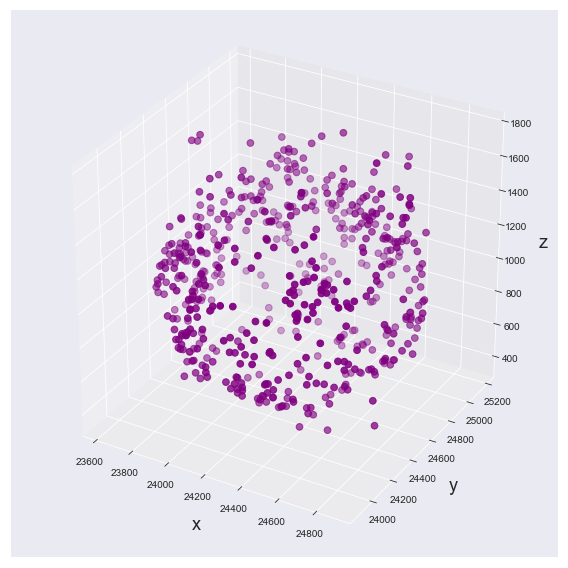

In [17]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter (xyz[:,0], xyz[:,1], xyz[:,2], s=45, c='purple', depthshade=True)
ax.set_xlabel('x', labelpad=10, fontsize=18), ax.set_ylabel('y', labelpad=10, fontsize=18), ax.set_zlabel('z', labelpad=10, fontsize=18)
plt.tight_layout();
# plt.savefig(path+"_mito3d");

In [ ]:
###3D plot with ipyvolume
import ipyvolume as ipv
ipv.quickscatter(xyz[:,0], xyz[:,1], xyz[:,2], size=10, marker="sphere")

In [ ]:
###matplotlib plot
# n = 10 #number of colors to iterate over
# colors = plt.cm.viridis(np.linspace(0,1,10))
# fig, ax = plt.subplots(figsize = (6,6))
# for curr_layer, color in zip(np.unique(layer), colors):
#     curr_xyz = dt[dt['layer'] == curr_layer] #filter for specified layer
#     curr_xyz = curr_xyz[['Xwc','Ywc', 'Zc']].values
#     ax.scatter(curr_xyz[:,0],curr_xyz[:,1], c=color, label=str(curr_layer))

# ax.set_aspect('equal')
# plt.legend(loc='upper right');

In [ ]:
###random points for trial plots
x = np.random.randint(100, size=(1, 500))
y = np.random.randint(100, size=(1, 500))

fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(x,y, s = 5);

<IPython.core.display.Javascript object>


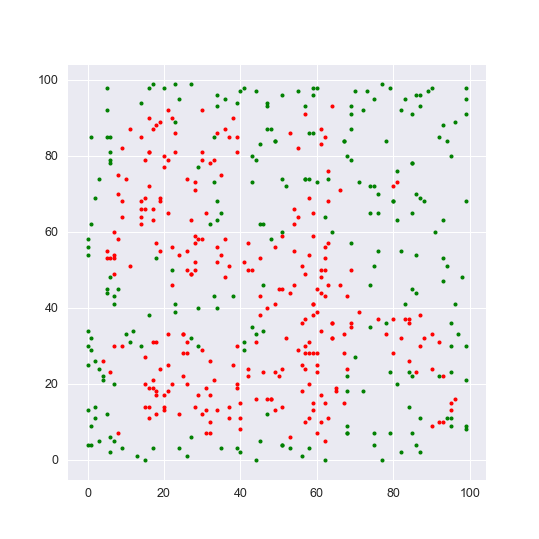

In [113]:
###density_based_coloring
#get restructured data 
import scipy.spatial as spatial
xy = np.concatenate((x,y))
xy = xy.T
#get KDtree and point numbers within epsilon from point in KDtree
tree = spatial.KDTree(xy)
eps = 10
neighbors = []
for i in tree.data:
    n = len(tree.query_ball_point(i, eps))-1
    neighbors.append(n)
#get points below/above specified vutoff value (mean dens)
mean = np.mean(neighbors)
normed_neighbors = np.array(neighbors)/mean

#plot data
fig, ax = plt.subplots(figsize = (6,6))
for i, dens in zip(xy, normed_neighbors):
    if dens < 1:
        color = 'green'
    if dens >=1:
        color = 'red'
    ax.scatter(i[0], i[1], s=5, c=color)

## Resources 

### 3D plots
- https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
- https://stackoverflow.com/questions/9170838/surface-plots-in-matplotlib- 
- https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
- plotly: https://plot.ly/python/3d-scatter-plots/
- Ipyvolume: bokeh / pyqt should be downgraded from 1.x -> 0.x / 5.x -> 4.x

### interactive matplotlib plots in Jupyter notebook 
- https://www.reddit.com/r/IPython/comments/36p360/try_matplotlib_notebook_for_interactive_plots/
- https://matplotlib.org/users/navigation_toolbar.html
- clicking on/off legends via matplotlib: https://matplotlib.org/gallery/event_handling/legend_picking.html

### density based coloring
- https://stackoverflow.com/questions/35824882/matplotlib-coloring-scatter-plot-based-on-relative-density
- https://stackoverflow.com/questions/14070565/calculating-point-density-using-python